# GWAS Prediction

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
import xgboost as xgb
import plotnine as p9
import scipy.stats
from plotnine import *
from torcheval.metrics import R2Score
import torch
from scipy.stats import wilcoxon, ttest_rel, ranksums

## Data Preparation

### Load Covariates

In [2]:
def build_control_covariates(metadata):
    genesize = metadata.NPARAM.values.astype(float)
    genedensity = metadata.NPARAM.values/metadata.NSNPS.values
    inverse_mac = 1.0/metadata.MAC.values
    cov = np.stack((genesize, np.log(genesize), genedensity, np.log(genedensity), inverse_mac, np.log(inverse_mac)), axis=1)
    return cov

def munge_sigma(magma_gene_raw):
    f = open(magma_gene_raw)
    lines = list(f)[2:]
    lines = [np.asarray(line.strip('\n').split(' ')) for line in lines]
    sigmas = []
    gene_metadata = []
    gene_lists = []
    for chrom in range(1,23):
        chr_start = min(np.where([int(line[1])==chrom for line in lines])[0])
        chr_end = max(np.where([int(line[1])==chrom for line in lines])[0])
        lines_chr = lines[chr_start:chr_end+1]
        n_genes = len(lines_chr)
        sigma_chr = np.zeros([n_genes, n_genes])
        gene_NSNPs = np.zeros(n_genes)
        gene_NPARAM = np.zeros(n_genes)
        gene_MAC = np.zeros(n_genes)
        for i in range(n_genes):
            line = lines_chr[i]
            gene_NSNPs[i] = line[4]
            gene_NPARAM[i] = line[5]
            gene_MAC[i] = line[7]
            if line.shape[0] > 9:
                gene_corrs = np.asarray([float(c) for c in line[9:]])
                sigma_chr[i, i-gene_corrs.shape[0]:i] = gene_corrs
        sigma_chr = sigma_chr+sigma_chr.T+np.identity(n_genes)
        sigmas.append(sigma_chr)
        gene_metadata_chr = pd.DataFrame(data={'NSNPS': gene_NSNPs, 'NPARAM': gene_NPARAM, 'MAC': gene_MAC})
        gene_metadata.append(gene_metadata_chr)
        gene_list_chr = [line[0] for line in lines_chr]
        gene_lists.append(gene_list_chr)
    return sigmas, gene_metadata, gene_lists

In [3]:
def get_covariates(metadata, gene_lists):
    # create covariates from pops
    covariates = []
    for i in range(0, 22):
        #print(i)
        covariates.append(pd.DataFrame(build_control_covariates(metadata[i]),
                                       index = gene_lists[i],
                                       columns = ['genesize',
                                                  'log_genesize',
                                                  'genedensity',
                                                  'log_genedensity',
                                                  'inverse_mac',
                                                  'log_inverse_mac'])
                          )
    covariates = pd.concat(covariates)
    return covariates

### Load Embeddings

In [4]:
def get_embeddings(emb_name):
    emb_path = '../data/embeddings/'+emb_name+'.tsv'
    emb = pd.read_csv(emb_path, sep = "\t").set_index("gene_id")
    return emb

### Load GWAS MAGMA Scores

In [5]:
def load_magma(trait, covariates):
    magma = pd.read_csv('../data/input/GWAS/'+trait+'.genes.out', delim_whitespace=True)
    magma = magma.merge(covariates, left_on = "GENE", right_index = True)
    return magma

### Project Y to LY

In [6]:
def compute_Ls(sigmas, Y):
    Ls = []
    min_lambda=0
    for sigma in sigmas:
        W = np.linalg.eigvalsh(sigma)
        min_lambda = min(min_lambda, min(W))
    #Y = pd.read_table(args.gene_results+'.genes.out', delim_whitespace=True).ZSTAT.values
    ridge = abs(min_lambda)+.05+.9*max(0, np.var(Y)-1)
    for sigma in sigmas:
        sigma = sigma+ridge*np.identity(sigma.shape[0])
        L = np.linalg.cholesky(np.linalg.inv(sigma))
        Ls.append(L)
    return Ls

In [7]:
def project_Y(Ls, magma, gene_lists):
    LYs = []
    for i in range(22):
        L = Ls[i]
        magma_temp = magma.set_index("GENE").reindex(gene_lists[i]).reset_index()

        LYs.append(pd.DataFrame({"GENE": magma_temp.GENE, "LY": np.matmul(L, magma_temp.ZSTAT)}))
    return pd.concat(LYs)

def project_Y_back(Ls, res, gene_lists):
    LYs = []
    for i in range(22):
        L = np.linalg.inv(Ls[i])
        temp = res.set_index("GENE").reindex(gene_lists[i]).reset_index()

        LYs.append(pd.DataFrame({"GENE": temp.dropna().GENE,
                                 "pred_null": np.matmul(L[~temp.pred_LY_null.isna(), :][:, ~temp.pred_LY_null.isna()],
                                                   temp.dropna().pred_LY_null),
                                 "pred": np.matmul(L[~temp.pred_LY.isna(), :][:, ~temp.pred_LY.isna()],
                                                   temp.dropna().pred_LY),
                                 }))
    return pd.concat(LYs)

### Merge Data

In [8]:
def prepare_data(trait, emb_name):
  sigmas, metadata, gene_lists = munge_sigma('../data/input/GWAS/'+trait+'.genes.raw')
  covariates = get_covariates(metadata, gene_lists)
  
  emb = get_embeddings(emb_name)
  
  magma = load_magma(trait, covariates)
  
  # Add Ls
  Ls = compute_Ls(sigmas, magma.ZSTAT)
  magma = magma.merge(project_Y(Ls, magma, gene_lists))
  
  # Merge everything
  data = magma.merge(emb, left_on = "GENE", right_on = "gene_id")
  dict = {"sigmas": sigmas, "metadata": metadata, "gene_lists": gene_lists, "covariates": covariates, "embeddings": emb, "Ls": Ls}
  return data, dict

## Regression

Split by Chromosomes.

In [9]:
def regression_chrom_cv(dt, emb_cols, Ls, gene_lists):
    results = []
    
    for chrom in range(1,23):
        reg_null = xgb.XGBRegressor(tree_method="hist", reg_lambda = 1000, reg_alpha = 100)
        reg_full = xgb.XGBRegressor(tree_method="hist", reg_lambda = 1000, reg_alpha = 100)
        
        # Null model (covariates only)
        mod_null = reg_null.fit(
            dt.query("CHR != @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1).drop(emb_cols, axis=1),
            dt.query("CHR != @chrom")['LY']
        )
        pred_null = mod_null.predict(
            dt.query("CHR == @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1).drop(emb_cols, axis=1),
        )
        
        # Full model
        mod_full = reg_full.fit(
            dt.query("CHR != @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1),
            dt.query("CHR != @chrom")['LY']
        )
        pred_full = mod_full.predict(
            dt.query("CHR == @chrom").drop(["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"], axis=1),
        )
    
        results_chrom = dt.query("CHR == @chrom")[["GENE", "CHR", "START", "STOP", "NSNPS", "NPARAM", "N", "ZSTAT", "P", "LY"]]
        results_chrom['pred_LY_null'] = pred_null
        results_chrom['pred_LY'] = pred_full
    
        results.append(results_chrom)
        print(f"Chrom {chrom}: R2 (null): {scipy.stats.pearsonr(results_chrom.LY, results_chrom.pred_LY_null)[0]**2}")
        print(f"Chrom {chrom}: R2: {scipy.stats.pearsonr(results_chrom.LY, results_chrom.pred_LY)[0]**2}")
    
    print()
    
    results = pd.concat(results)
    results = results.merge(project_Y_back(Ls, results, gene_lists))
    
    print(f"Overall R2 (null): {scipy.stats.pearsonr(results.ZSTAT, results.pred_null)[0]**2}")
    print(f"Overall R2: {scipy.stats.pearsonr(results.ZSTAT, results.pred)[0]**2}")

    return results

In [10]:
def get_results(trait, model_names):
    print("# Trait:", trait)
    
    results = []
    
    for model in model_names:
        print("## Model:", model)
        data, metadata = prepare_data(trait, model)
        emb_cols = metadata["embeddings"].columns.to_list()
        Ls = metadata["Ls"]
        gene_lists = metadata["gene_lists"]
        reg_results = regression_chrom_cv(data, emb_cols, Ls, gene_lists)
        
        r2_null=[]
        r2_full=[]
        for i in range(1,23):
            df = reg_results.query("CHR == @i")
            r2_null.append(R2Score().update(torch.tensor(df["pred_null"].values), torch.tensor(df["ZSTAT"].values)).compute().numpy())
            r2_full.append(R2Score().update(torch.tensor(df["pred"].values), torch.tensor(df["ZSTAT"].values)).compute().numpy())
        
        res = {'name': model, 'reg_results': reg_results, 'full': np.array(r2_full), 'null': np.array(r2_null)}
        results.append(res)
        print()
    return results

## Plotting

In [11]:
def r2_per_chrom(reg_results):
    print("Per chrom R2 (full):")

    per_chrom_r2 = []
    for i in range(1, 23):
        res_tmp = reg_results.query("CHR == @i")
        r2 = scipy.stats.pearsonr(res_tmp.ZSTAT, res_tmp.pred)[0]**2
        per_chrom_r2.append(r2)
        print(r2)
    
    chromosomes = list(range(1, 23))
    df = pd.DataFrame({'Chromosome': chromosomes, 'R2': per_chrom_r2})
    
    # Plot R^2 values across chromosomes
    return (ggplot(df, aes(x='factor(Chromosome)', y='R2')) +
     geom_bar(stat='identity') +
     labs(title='R^2 Across Chromosomes', x='Chromosome', y='R2'))

In [12]:
# scatter plot (of predicted vs. true values)
def scatter(dataframe, x, y, x_label, y_label, color=None, alpha=0.1, smooth=True, facet=None):
    if color is not None:
        dataframe[color] = pd.Categorical(dataframe[color])
        p = ggplot(dataframe, aes(x, y, color=color)) + geom_point(alpha=alpha) + labs(x=x_label, y=y_label)
    else:
        p = ggplot(dataframe, aes(x, y)) + geom_point(alpha=alpha) + labs(x=x_label, y=y_label)
    if smooth:
        p += geom_smooth(method="lm")
    if facet:
        p += facet_wrap("~" + facet)
    p += geom_abline()
    return p

## Comparing Results

In [13]:
# plot r2 score
def compare_r2(dataframe=None, true = "ZSTAT", null = "pred_null", full="pred", r2_null=None, r2_full=None, r2_null_name="r2_null", r2_full_name="r2_full"):
    if dataframe is not None:
        r2_null=[]
        r2_full=[]
        for i in range(1,23):
            df = dataframe.query("CHR == @i")
            r2_null.append(R2Score().update(torch.tensor(df[null].values), torch.tensor(df[true].values)).compute().numpy())
            r2_full.append(R2Score().update(torch.tensor(df[full].values), torch.tensor(df[true].values)).compute().numpy())
    r2 = pd.DataFrame({
        r2_null_name: np.array(r2_null),
        r2_full_name: np.array(r2_full),
        "r2_delta": (np.array(r2_full) - np.array(r2_null))})
    df1 = pd.melt(r2, value_vars=[r2_null_name, r2_full_name], var_name="model", value_name="r2")
    p1 = ggplot(df1, aes("model","r2")) + geom_boxplot()
    p2 = ggplot(r2, aes("r2_delta")) + geom_histogram()

    t_stat, t_p_value = ttest_rel(r2[r2_null_name], r2[r2_full_name])
    print(f't-test p-value for the difference in means: {t_p_value:.4f}')
    
    w_stat, w_p_value = wilcoxon(r2[r2_null_name], r2[r2_full_name])
    print(f'Wilcoxon p-value: {w_p_value:.4f}')

    r_stat, r_p_value = ranksums(r2[r2_null_name], r2[r2_full_name])
    print(f'Ranksums p-value: {r_p_value:.4f}')
    
    # Add p-values to the plot
    p1 = p1 + labs(subtitle=f'Wilcoxon p = {w_p_value:.4f}, Ranksum p = {r_p_value:.4f}, t-test p = {t_p_value:.4f}')
    
    return p1 #, p2

In [14]:
def compare_r2_across_models(model_results):
    data_table = pd.DataFrame()

    for model_result in model_results:
        model_name = model_result['name']
        delta_r2_column = f'delta_r2_{model_name}'
        data_table[delta_r2_column] = model_result['full'] - model_result['null']

    # Melt the DataFrame
    data_table = pd.melt(data_table, var_name='model', value_name='delta_r2')

    # Plot using plotnine
    return (ggplot(data_table, aes(x='model', y='delta_r2')) +
            geom_boxplot())

# Run

In [15]:
trait = 'HDL_cholesterol'
models = ["Omics_d256", "GTEx_PCA_d64"]

In [16]:
results = get_results(trait, models)

# Trait: HDL_cholesterol
## Model: Omics_d256
Chrom 1: R2 (null): 0.05508434364471915
Chrom 1: R2: 0.07525334525537461
Chrom 2: R2 (null): 0.10211750917037472
Chrom 2: R2: 0.11041946486781463
Chrom 3: R2 (null): 0.05599344470202439
Chrom 3: R2: 0.07101397097248709
Chrom 4: R2 (null): 0.055583756751398414
Chrom 4: R2: 0.06367080705018728
Chrom 5: R2 (null): 0.08314665048925271
Chrom 5: R2: 0.07676319218327589
Chrom 6: R2 (null): 0.03040579132583941
Chrom 6: R2: 0.03075019478768777
Chrom 7: R2 (null): 0.03702423742356356
Chrom 7: R2: 0.053877252939014124
Chrom 8: R2 (null): 0.06075128515720038
Chrom 8: R2: 0.07305649129367954
Chrom 9: R2 (null): 0.05655140705648155
Chrom 9: R2: 0.06310958093218305
Chrom 10: R2 (null): 0.060626226282980936
Chrom 10: R2: 0.07321509777592132
Chrom 11: R2 (null): 0.03630044173363545
Chrom 11: R2: 0.05258632445117058
Chrom 12: R2 (null): 0.029402214576346567
Chrom 12: R2: 0.05650955600295825
Chrom 13: R2 (null): 0.07978180734960907
Chrom 13: R2: 0.09195255493

## General Comparison

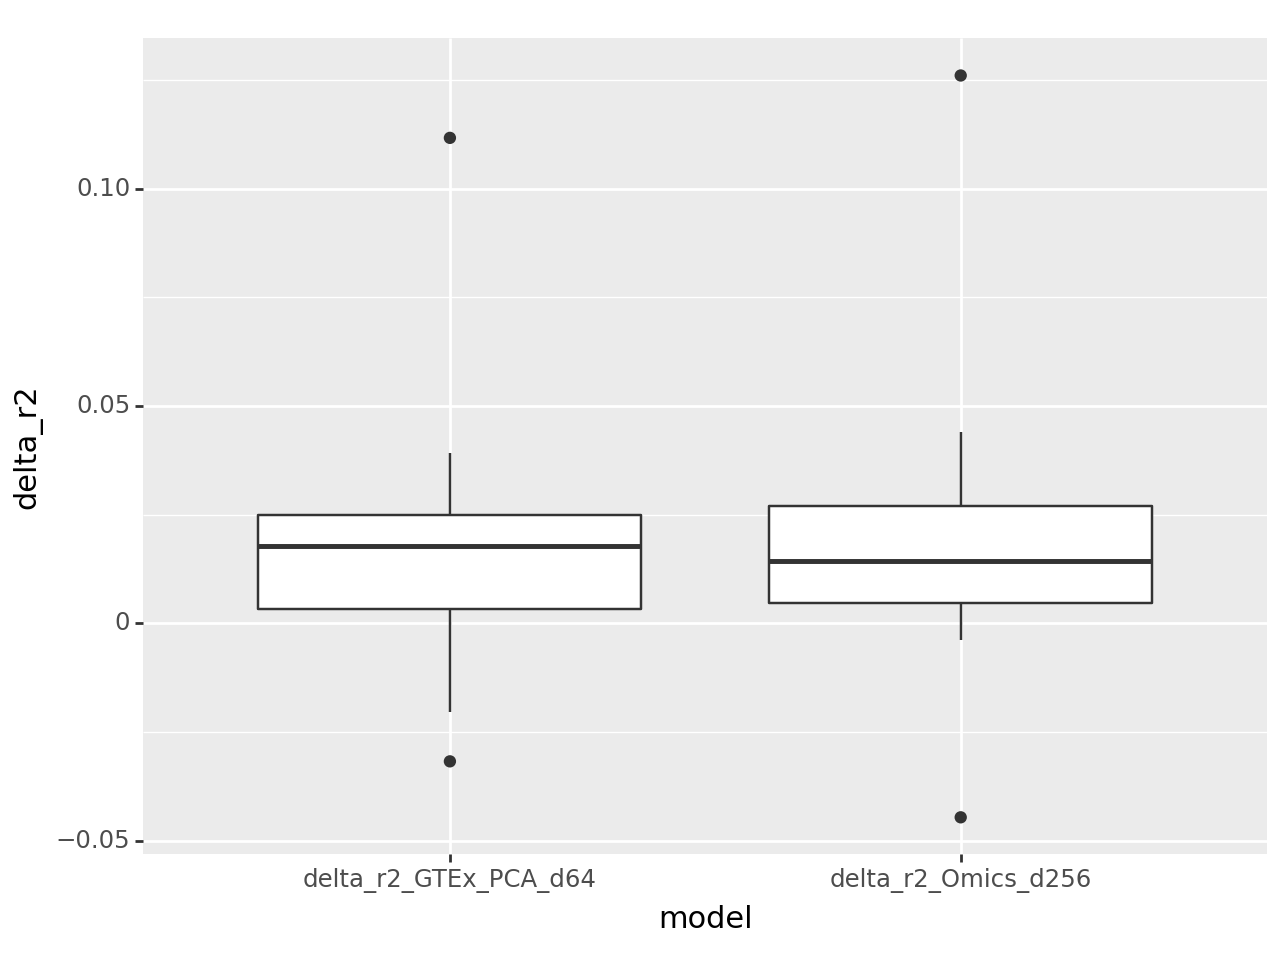

<Figure Size: (640 x 480)>

In [17]:
compare_r2_across_models(results)

t-test p-value for the difference in means: 0.7723
Wilcoxon p-value: 0.6789
Ranksums p-value: 0.8695


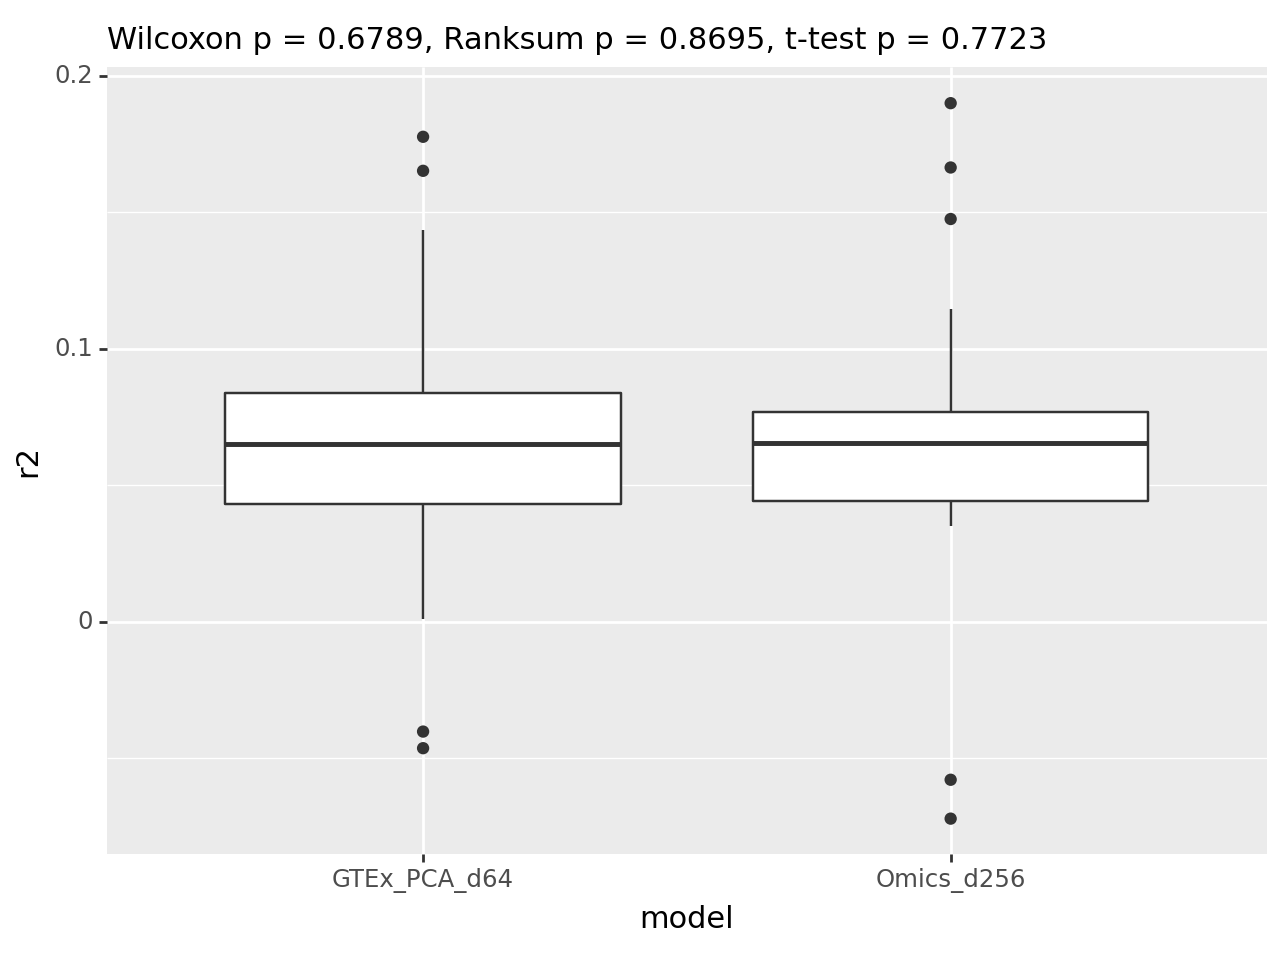

<Figure Size: (640 x 480)>

In [18]:
compare_r2(r2_null_name=results[0]["name"], r2_null=results[0]["full"], r2_full_name=results[1]["name"], r2_full=results[1]["full"])

## Omics

In [19]:
res_omics = results[0]['reg_results']

Per chrom R2 (full):
0.0804065433444994
0.06725134335099976
0.18181764973308354
0.07327736017959016
0.03059141850620522
0.21989611128886694
0.05037218461677569
0.0696986472443637
0.0721257922657933
0.05950166924611103
0.10244032574834419
0.10287346419521598
0.07500605891411542
0.09388329220762026
0.0945153128694408
0.13868946663522497
0.07788948703565064
0.04909639281480897
0.03774504139548425
0.1697583535981759
0.2739760229354141
0.07864224555615076


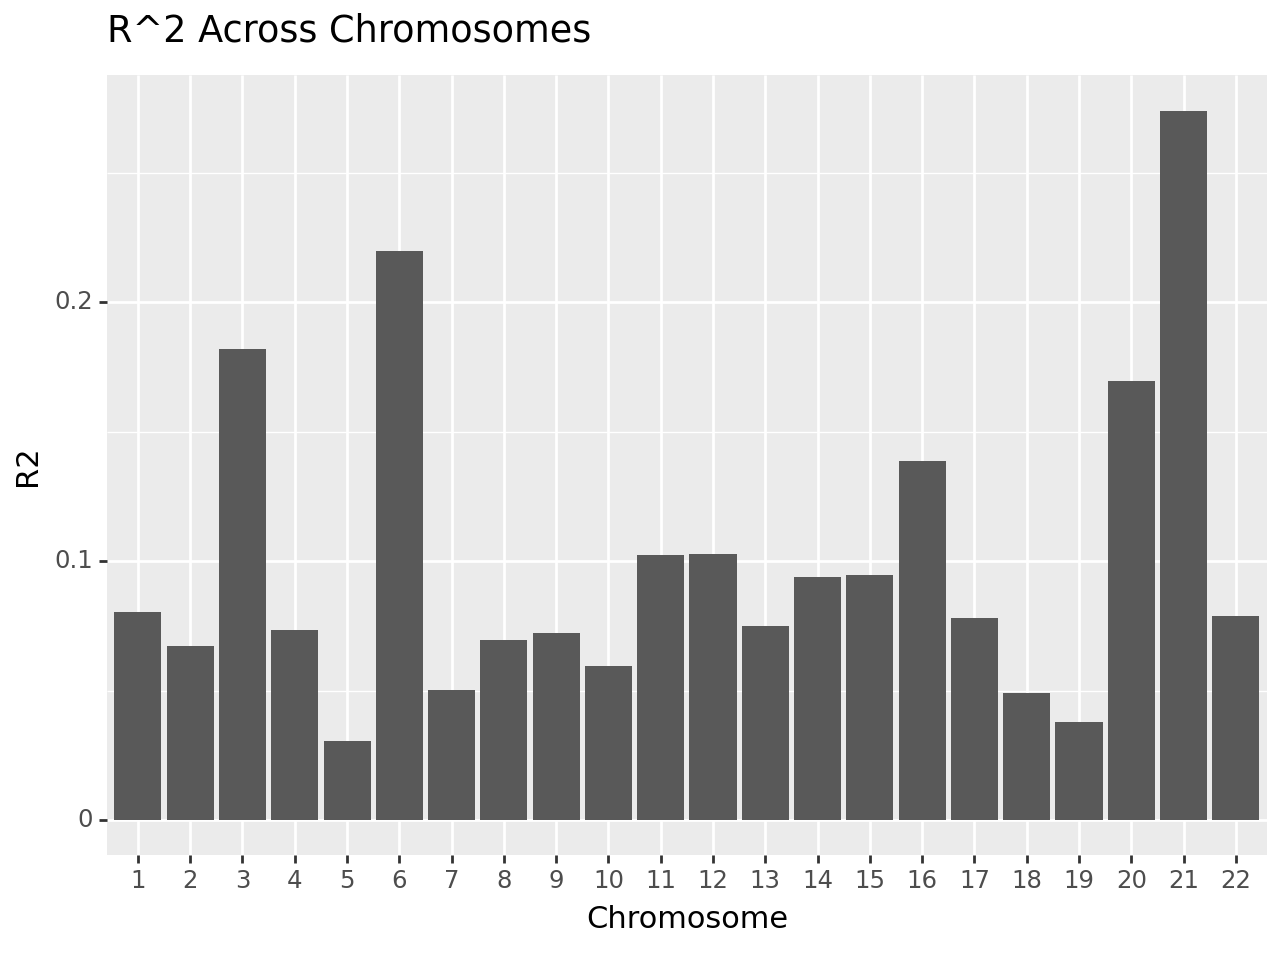

<Figure Size: (640 x 480)>

In [20]:
r2_per_chrom(res_omics)

t-test p-value for the difference in means: 0.0104
Wilcoxon p-value: 0.0004
Ranksums p-value: 0.0604


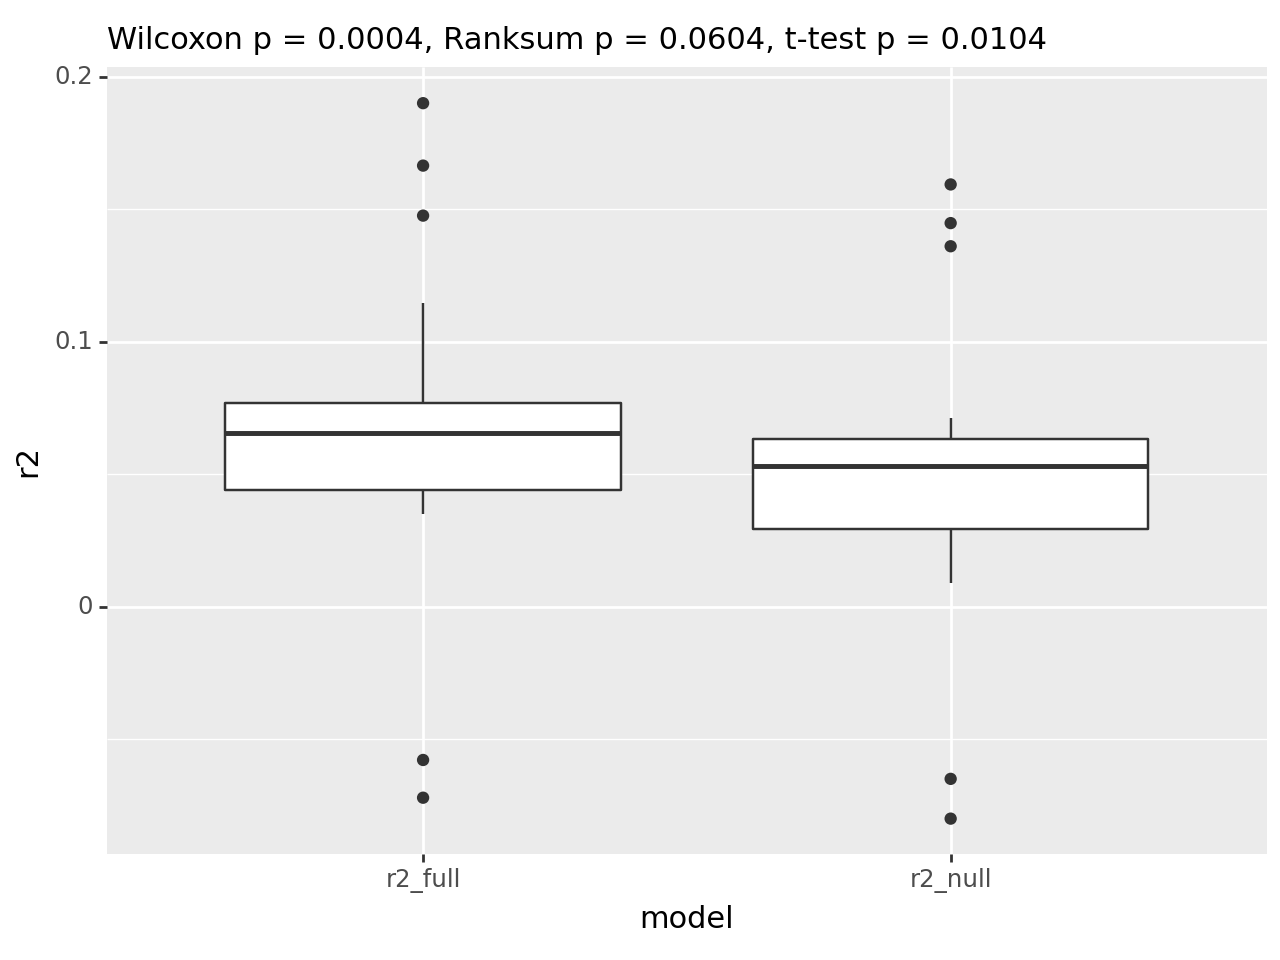

<Figure Size: (640 x 480)>

In [21]:
compare_r2(res_omics)

## GTEx PCA

In [22]:
res_gtex_pca = results[1]['reg_results']

Per chrom R2 (full):
0.07948893460570777
0.06065681115452023
0.1955257717627445
0.07300279851910552
0.03675052983009157
0.24809915289953316
0.054853661831332154
0.05642339138999417
0.08786142226265252
0.05449199336946204
0.1013296562029893
0.08767578742499506
0.04702820343345462
0.07505478817395267
0.10200400712668357
0.13516020288073505
0.08252471561735927
0.04653588037736781
0.03963303158023101
0.17419851988477175
0.2723440853523539
0.09369455745782088


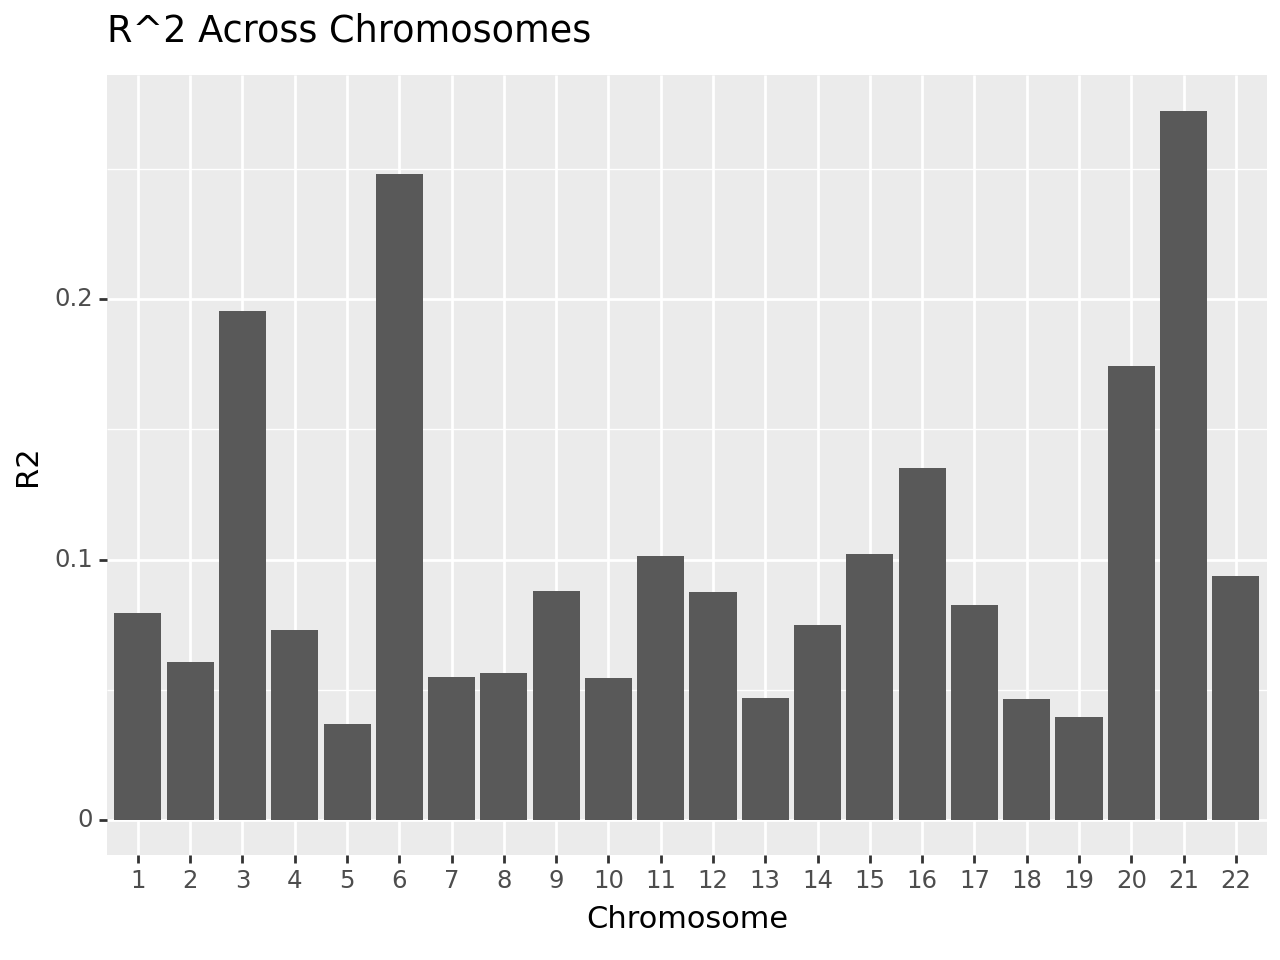

<Figure Size: (640 x 480)>

In [23]:
r2_per_chrom(res_gtex_pca)

t-test p-value for the difference in means: 0.0112
Wilcoxon p-value: 0.0047
Ranksums p-value: 0.1887


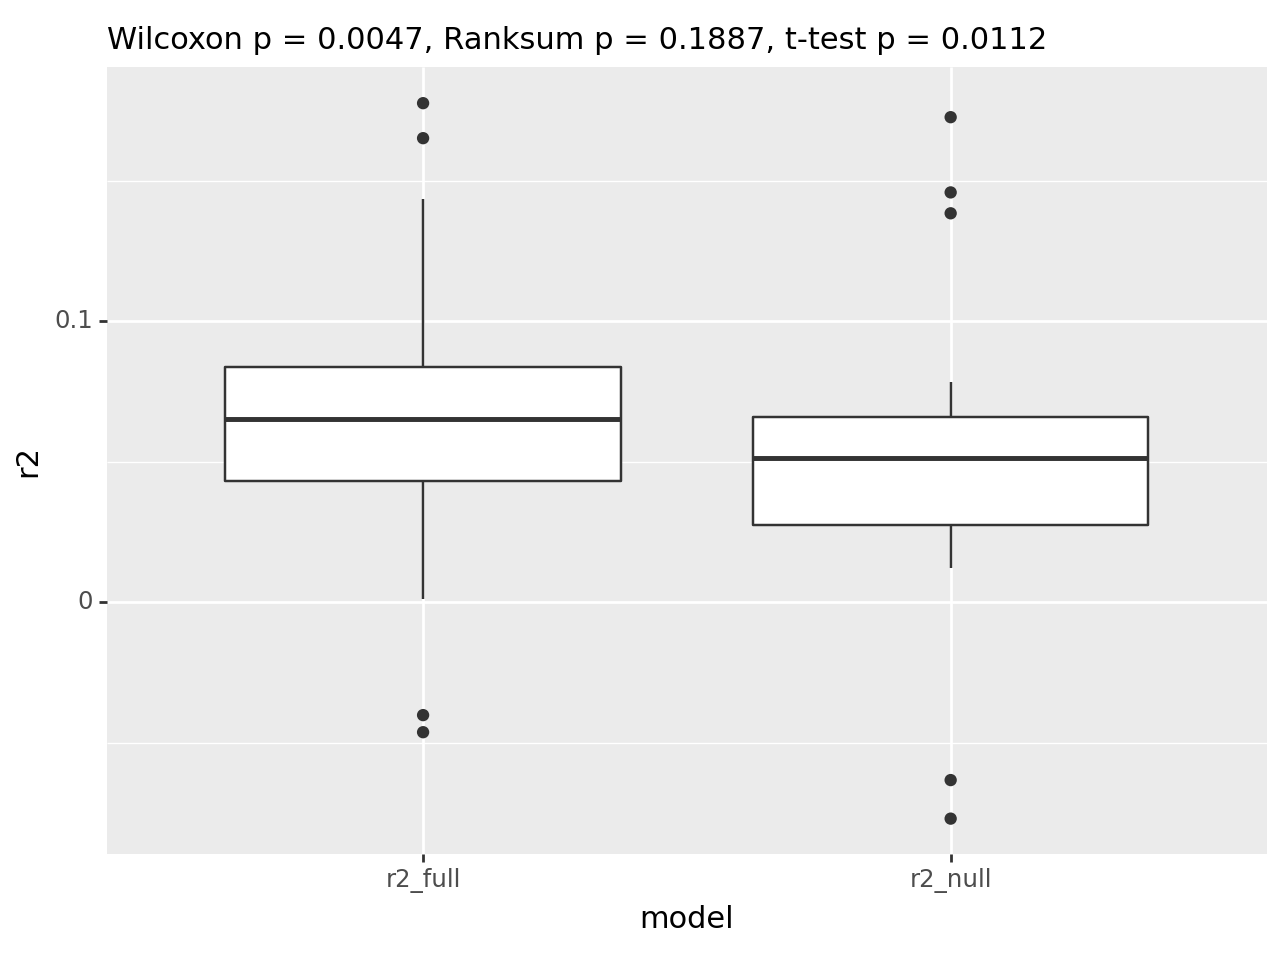

<Figure Size: (640 x 480)>

In [24]:
compare_r2(res_gtex_pca)